In [1]:
import pickle as pk
import tensorflow as tf
import numpy as np
import tensorflow as tf
from tensorflow.keras import regularizers

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

import os, sys, pathlib, h5py, time

from models import make_model

from astropy.nddata import block_reduce

from matplotlib import pyplot as plt

from astropy.io import fits

%load_ext autoreload
%autoreload 2

%matplotlib inline

2022-12-01 16:17:49.441485: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31016 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0004:04:00.0, compute capability: 7.0
2022-12-01 16:17:49.444139: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31016 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0004:05:00.0, compute capability: 7.0
2022-12-01 16:17:49.446528: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 31016 MB memory:  -> device: 2, name: Tesla V100-SXM2-32GB, pci bus id: 0035:03:00.0, compute capability: 7.0
2022-12-01 16:17:49.448896: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 31016 MB memory:  -> device: 3, name: Tesla V100-SXM2-32GB, pci bus id

# Load and perform some cuts on data

In [2]:
data_dir = '/project/r/rbond/jorlo/datasets/act_freq_stamps/'

with np.load(data_dir + 'all_clusters.npz') as data:
    stamps = data['arr_0']


In [3]:
stamps.shape

(4195, 41, 41, 3)

In [4]:
#cuts out any maps that have nans in them
flags = []
for i in range(stamps.shape[0]):
        if np.any(np.isnan(stamps[i,...])):
                flags.append(i)

stamps = np.delete(stamps, flags, axis = 0)

In [5]:
stamps.shape

(4195, 41, 41, 3)

In [6]:
tot = stamps.shape[0]
train_size = int(0.7 * tot)
val_size = int(0.15 * tot)
test_size = int(0.15 * tot)

train_stamps = stamps[:train_size]
val_stamps = stamps[train_size:train_size + val_size]
test_stamps = stamps[train_size + val_size:]

input_shape = train_stamps.shape[1:]

act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')

labels = act_catalog[1].data['M500Cal']

train_labels = labels[:train_size]
val_labels = labels[train_size:train_size + val_size]
test_labels = labels[train_size + val_size:]

#This just sets the # of samples we include in a trianing epoch, which is called the batch size. Autotune is a bit
#of magic that allows tf to dynamically set some hyperparameters in an optimal way. See https://www.tensorflow.org/guide/data_performance
batch_size = 500
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((train_stamps, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_stamps, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_stamps, test_labels))

#We shuffle our data (i.e. just mix up the order) and batch it
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(batch_size)

#Preloads data into memory
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

2022-12-01 16:17:55.739806: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31016 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0004:04:00.0, compute capability: 7.0
2022-12-01 16:17:55.742097: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31016 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0004:05:00.0, compute capability: 7.0
2022-12-01 16:17:55.744374: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 31016 MB memory:  -> device: 2, name: Tesla V100-SXM2-32GB, pci bus id: 0035:03:00.0, compute capability: 7.0
2022-12-01 16:17:55.746634: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 31016 MB memory:  -> device: 3, name: Tesla V100-SXM2-32GB, pci bus id

# A simple Dense Model

In [7]:
model = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape=input_shape),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1)
  ])

model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 5043)              0         
                                                                 
 dense (Dense)               (None, 64)                322816    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 327,041
Trainable params: 327,041
Non-trainable params: 0
_________________________________________________________________


In [10]:
toc = time.time()
#Actually fits the model to the data. data_augmentation.flow generates augmented data sets from the data sets we pass it.
#Epochs sets the number of rounds of fitting to perform. 
history = model.fit(train_dataset, epochs=int(50), 
                    validation_data=val_dataset)
tic = time.time()

print('Distributed time: ', tic-toc)

#Evaluate how well our model does
test_loss = model.evaluate(test_dataset, verbose=2)




Epoch 1/50
6/6 [==============================] - 0s 21ms/step - loss: 0.1419 - val_loss: 1.0395
Epoch 2/50
6/6 [==============================] - 0s 21ms/step - loss: 0.1268 - val_loss: 1.0511
Epoch 3/50
6/6 [==============================] - 0s 22ms/step - loss: 0.1238 - val_loss: 1.0405
Epoch 4/50
6/6 [==============================] - 0s 19ms/step - loss: 0.1289 - val_loss: 1.0298
Epoch 5/50
6/6 [==============================] - 0s 20ms/step - loss: 0.1522 - val_loss: 1.0283
Epoch 6/50
6/6 [==============================] - 0s 19ms/step - loss: 0.1456 - val_loss: 1.0664
Epoch 7/50
6/6 [==============================] - 0s 22ms/step - loss: 0.1512 - val_loss: 1.0327
Epoch 8/50
6/6 [==============================] - 0s 21ms/step - loss: 0.1355 - val_loss: 1.0352
Epoch 9/50
6/6 [==============================] - 0s 22ms/step - loss: 0.1265 - val_loss: 1.0418
Epoch 10/50
6/6 [==============================] - 0s 21ms/step - loss: 0.1283 - val_loss: 1.0372
Epoch 11/50
6/6 [============

In [18]:
predictions = model.predict(train_dataset)
for i in range(len(train_labels)):
    print(train_labels[i]-predictions[i])
#It does shit

[-2.5906658]
[1.2040296]
[0.49915338]
[-1.1798217]
[-0.60637474]
[0.5996554]
[-2.9319804]
[0.4664452]
[1.0314977]
[1.4875128]
[-0.21164083]
[-0.4937005]
[0.11602354]
[0.15286517]
[0.69392014]
[-1.0606194]
[-1.9083014]
[1.030843]
[0.2873845]
[0.09402871]
[-2.6321845]
[-0.13822818]
[5.5088434]
[-0.4602809]
[-0.09376311]
[2.590231]
[-2.9075315]
[-0.45516562]
[3.4871633]
[1.615052]
[-3.3651204]
[1.0222437]
[1.0185881]
[-2.231366]
[0.3542235]
[-0.38485026]
[2.7832446]
[-0.03962994]
[0.18495846]
[0.27183127]
[1.4459851]
[-0.17398834]
[-0.5547795]
[1.1970694]
[-0.6968148]
[-0.9715955]
[1.6127036]
[-3.7314239]
[1.957612]
[0.920408]
[0.89364934]
[1.5687435]
[1.0057046]
[-0.4409399]
[0.28468478]
[-0.41428065]
[-1.4999955]
[-0.19863868]
[0.2859118]
[-0.3339932]
[-1.1187816]
[0.24899197]
[-3.5828037]
[0.5825021]
[-0.7662916]
[-2.974993]
[3.841363]
[0.94103694]
[-2.2339575]
[0.5566106]
[-1.3926811]
[-0.96592855]
[-0.7644367]
[1.1777551]
[0.79206276]
[-4.6095324]
[0.46955395]
[-0.14666724]
[2.172226

[2.6571672]
[5.8272133]
[3.7406964]
[0.49288106]
[-0.44842482]
[1.0195963]
[-6.3717537]
[0.6406896]
[-0.32476783]
[-5.5517373]
[-0.6083498]
[-1.6633263]
[-1.4558606]
[-0.18091345]
[-1.1467521]
[-0.6819954]
[5.889984]
[1.0198052]
[2.3628247]
[-0.01603174]
[1.0092974]
[0.89738536]
[1.8949134]
[0.4380083]
[0.25236225]
[1.6761537]
[0.9586549]
[0.8560915]
[1.6023815]
[0.8225751]
[1.8865607]
[-1.24417]
[-0.8539572]
[1.5789685]
[-0.43849182]
[0.6907368]
[0.19477773]
[1.6546452]
[1.121758]
[0.04208803]
[-3.2608194]
[-2.4074745]
[-0.42624164]
[-0.14552546]
[-1.6401289]
[-0.5820215]
[-0.5127659]
[1.8331144]
[1.3241651]
[-0.658854]
[-0.43363762]
[1.0290539]
[0.795604]
[0.20980859]
[-1.0103261]
[4.1446056]
[0.4291637]
[0.56591034]
[1.1313882]
[0.10677624]
[-0.17018056]
[-2.6055088]
[1.5006189]
[-0.60562253]
[-1.1624424]
[-0.9453056]
[-0.20026469]
[-4.244191]
[1.6081295]
[1.1297722]
[-0.6651814]
[0.50396943]
[1.0778644]
[1.7571411]
[-0.73744845]
[-0.82185316]
[-9.574521]
[-0.22257638]
[0.6647239]
[

[0.0423429]
[-0.07867765]
[-0.31428874]
[-0.02954531]
[-1.4794261]
[-1.1527784]
[0.51682615]
[-1.548785]
[-2.2979026]
[-1.4753141]
[-0.6910441]
[-0.16951156]
[-0.0679369]
[-0.46531272]
[-1.6660173]
[-3.5484672]
[0.31067634]
[-0.8280616]
[0.9710796]
[-1.0117521]
[0.1716001]
[4.1280637]
[1.7028182]
[-0.01510262]
[0.1440072]
[0.44389415]
[-0.73741174]
[1.8505018]
[-1.1508358]
[-0.545665]
[-2.6394577]
[0.49557662]
[-2.0787165]
[0.15400362]
[-1.1963756]
[-3.4697251]
[-1.6609311]
[-0.14669323]
[-0.9657371]
[-0.18220735]
[1.0335655]
[0.44599724]
[2.0142765]
[-1.7372139]
[3.3394787]
[0.83765554]
[0.14459944]
[-2.443607]
[0.7680135]
[2.948439]
[0.60704017]
[-1.7415628]
[1.0063531]
[0.46772385]
[-2.699362]
[-0.63039255]
[-0.41029787]
[-0.10584307]
[-3.6318758]
[-1.311228]
[-0.573843]
[1.2154806]
[1.4873786]
[-1.2168133]
[0.5320904]
[-1.306359]
[0.5010319]
[0.19960499]
[-0.8258052]
[0.43910003]
[0.11070585]
[-5.4921064]
[2.235954]
[-0.9530386]
[-3.0191662]
[-0.4242339]
[0.60926914]
[0.07015085]
[

# CNN Model

In [23]:
#Very simple model, this is just from the TF tutorial

from tensorflow.keras import layers

model = tf.keras.models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

In [24]:
toc = time.time()
#Actually fits the model to the data. data_augmentation.flow generates augmented data sets from the data sets we pass it.
#Epochs sets the number of rounds of fitting to perform. 
history = model.fit(train_dataset, epochs=int(50), 
                    validation_data=val_dataset)
tic = time.time()

print('Distributed time: ', tic-toc)

#Evaluate how well our model does
test_loss = model.evaluate(test_dataset, verbose=2)

Epoch 1/50


2022-12-01 16:25:33.037721: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-12-01 16:25:48.716154: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-01 16:25:48.716744: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-01 16:25:48.716770: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-01 16:25:48.717343: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-01 16:25:48.717389: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


6/6 [==============================] - 29s 109ms/step - loss: 2.2593 - val_loss: 2.0051
Epoch 2/50
6/6 [==============================] - 0s 27ms/step - loss: 1.5075 - val_loss: 1.4121
Epoch 3/50
6/6 [==============================] - 0s 26ms/step - loss: 1.1815 - val_loss: 1.2268
Epoch 4/50
6/6 [==============================] - 0s 27ms/step - loss: 1.0488 - val_loss: 1.0591
Epoch 5/50
6/6 [==============================] - 0s 25ms/step - loss: 0.9751 - val_loss: 0.9975
Epoch 6/50
6/6 [==============================] - 0s 26ms/step - loss: 0.9175 - val_loss: 0.9396
Epoch 7/50
6/6 [==============================] - 0s 26ms/step - loss: 0.8715 - val_loss: 0.9175
Epoch 8/50
6/6 [==============================] - 0s 26ms/step - loss: 0.8311 - val_loss: 0.9306
Epoch 9/50
6/6 [==============================] - 0s 24ms/step - loss: 0.8453 - val_loss: 0.9166
Epoch 10/50
6/6 [==============================] - 0s 24ms/step - loss: 0.7862 - val_loss: 0.8905
Epoch 11/50
6/6 [=====================

In [25]:
predictions = model.predict(train_dataset)
for i in range(len(train_labels)):
    print(train_labels[i]-predictions[i])
#It does shit

[-2.448989]
[-0.7305465]
[1.1285102]
[-0.5290966]
[-0.3647902]
[-0.99399185]
[-0.3700812]
[-0.3339367]
[1.0647032]
[0.02942443]
[-0.7277627]
[-6.608738]
[-0.3668635]
[0.8408966]
[0.12474251]
[0.21423817]
[-0.62288594]
[0.12358236]
[-1.9726143]
[-1.05337]
[-0.7951803]
[-0.6519418]
[6.294983]
[-0.6938989]
[-0.64493656]
[1.687222]
[-3.1688273]
[-0.33784652]
[3.4917939]
[0.87574434]
[-1.8248158]
[1.3986583]
[-0.08506179]
[-0.5909538]
[0.88885427]
[-0.35102248]
[2.8008468]
[-0.25446725]
[-1.189853]
[0.67872715]
[-1.3673472]
[0.1596744]
[-0.2015562]
[0.24290991]
[-1.787739]
[-1.3864398]
[0.13394189]
[-0.36468172]
[2.9484491]
[0.6367724]
[0.4575088]
[-0.27144527]
[0.5518811]
[-0.38079977]
[-0.6235533]
[-1.351007]
[0.14362001]
[-0.92976046]
[1.0883563]
[-0.990721]
[-2.5272787]
[-0.5768392]
[-0.869884]
[0.54195905]
[-0.82543135]
[0.2535932]
[5.3746786]
[0.29229832]
[-0.2915988]
[0.4678688]
[-0.1878295]
[-1.7259083]
[0.43781424]
[1.9245164]
[1.0113707]
[-1.6840284]
[-0.38675666]
[-1.8785069]
[1.

[-0.64914227]
[1.3325598]
[-1.130724]
[1.0031874]
[-4.9193645]
[-0.5388243]
[0.91131973]
[-1.9839716]
[-1.1549578]
[-1.7695215]
[0.3062234]
[-0.51760125]
[-3.0547779]
[0.13923836]
[-2.8661568]
[0.32920027]
[-0.03470945]
[-0.8457954]
[0.9084432]
[-1.2387466]
[0.6195786]
[-0.152076]
[-2.0734828]
[-1.9701922]
[-1.3276925]
[-0.32264066]
[-0.9984491]
[-5.5732307]
[0.30131817]
[2.4389021]
[-1.5337129]
[-1.1952572]
[0.90840197]
[0.02380943]
[1.0867639]
[0.30600023]
[0.0262816]
[-0.5598943]
[-0.36673212]
[0.4927206]
[-1.5888278]
[0.13283968]
[0.67552257]
[0.85711336]
[-2.956959]
[-0.63032055]
[-1.1552206]
[-0.11492848]
[0.58552575]
[0.21120119]
[0.62707233]
[-1.5474358]
[2.4472542]
[1.7017488]
[-2.4222016]
[-0.11656427]
[-1.5774953]
[-0.46264243]
[-2.0500853]
[-1.61854]
[-0.10435057]
[1.5306823]
[1.1105239]
[1.3529897]
[-0.00723433]
[2.4233768]
[-0.0116508]
[0.44413638]
[1.3525116]
[0.35501957]
[-0.3799684]
[1.6839375]
[-2.3547096]
[-1.2794676]
[0.47233844]
[-0.5893526]
[0.4109764]
[-0.4725032

[1.0587053]
[-0.9414444]
[0.47717237]
[2.0672538]
[1.0928919]
[-0.7209034]
[-0.40715122]
[-0.74695253]
[-0.46580863]
[-1.3946435]
[0.13064456]
[-1.0850849]
[-1.5224755]
[-2.5074644]
[-0.42348886]
[1.055902]
[3.9293618]
[1.043468]
[-0.03602481]
[0.15301466]
[-0.21955085]
[-2.4550498]
[-0.5416646]
[0.7282672]
[-0.60993934]
[-2.8770938]
[-0.61746955]
[-0.8398967]
[2.1392944]
[0.23343611]
[0.2798655]
[-0.17248368]
[0.46316028]
[0.2634294]
[1.8044422]
[0.60225034]
[-0.18942666]
[0.2782755]
[-0.6938536]
[0.23541212]
[0.59407187]
[3.9022894]
[-0.9035914]
[1.6741047]
[1.0337589]
[-0.07532501]
[-5.008397]
[0.03002095]
[-0.60108495]
[1.0306401]
[0.6736758]
[-3.155481]
[0.773118]
[-2.6530402]
[-0.27790475]
[-0.53858423]
[0.07085609]
[-1.3982418]
[-0.04944611]
[0.38406873]
[-4.4528556]
[-0.177531]
[1.6289011]
[-0.9860339]
[0.32460594]
[-1.0343356]
[-0.75334644]
[0.8894203]
[-0.896847]
[-4.5548153]
[-1.1985457]
[0.9172063]
[0.8895922]
[-2.719245]
[1.4430733]
[-2.0767949]
[0.08761215]
[-0.48888254]


In [32]:
from tensorflow.keras import optimizers, layers, models, regularizers

model = tf.keras.models.Sequential([
layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer= regularizers.l2(0.001), input_shape=input_shape),
layers.MaxPooling2D(),
layers.Dropout(0.2),
layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer = regularizers.l2(0.001)),
layers.MaxPooling2D(),
layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer = regularizers.l2(0.001)),
layers.MaxPooling2D(),
layers.Dropout(0.2),
layers.Flatten(),
layers.Dense(512, activation='relu', kernel_regularizer = regularizers.l2(0.001)),
layers.Dense(2)])

model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))



In [35]:
toc = time.time()
#Actually fits the model to the data. data_augmentation.flow generates augmented data sets from the data sets we pass it.
#Epochs sets the number of rounds of fitting to perform. 

data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=360, width_shift_range=4,
    height_shift_range=4,zoom_range=0.3)


history = model.fit(data_augmentation.flow(train_stamps, train_labels), epochs=int(50), 
                    validation_data=val_dataset)
tic = time.time()

print('Distributed time: ', tic-toc)

#Evaluate how well our model does
test_loss = model.evaluate(test_dataset, verbose=2)

Epoch 1/50
92/92 [==============================] - 3s 23ms/step - loss: 0.9632 - val_loss: 0.9910
Epoch 2/50
92/92 [==============================] - 2s 24ms/step - loss: 0.8939 - val_loss: 0.9876
Epoch 3/50
92/92 [==============================] - 2s 24ms/step - loss: 0.8773 - val_loss: 0.9375
Epoch 4/50
92/92 [==============================] - 2s 23ms/step - loss: 0.8628 - val_loss: 1.0255
Epoch 5/50
92/92 [==============================] - 2s 23ms/step - loss: 0.8110 - val_loss: 0.9692
Epoch 6/50
92/92 [==============================] - 2s 23ms/step - loss: 0.8129 - val_loss: 0.9733
Epoch 7/50
92/92 [==============================] - 2s 23ms/step - loss: 0.7913 - val_loss: 0.9357
Epoch 8/50
92/92 [==============================] - 2s 24ms/step - loss: 0.7803 - val_loss: 0.8934
Epoch 9/50
92/92 [==============================] - 2s 24ms/step - loss: 0.7693 - val_loss: 0.8994
Epoch 10/50
92/92 [==============================] - 2s 23ms/step - loss: 0.7721 - val_loss: 0.8937
Epoch 11/

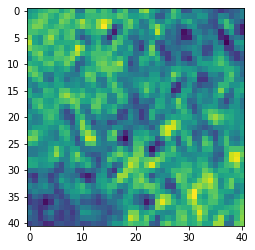

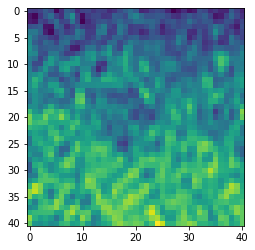

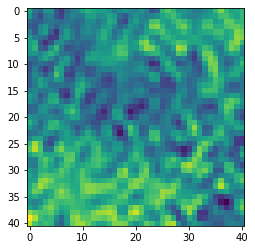

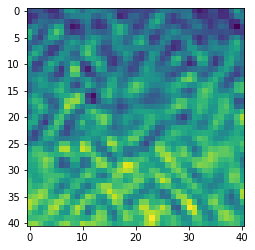

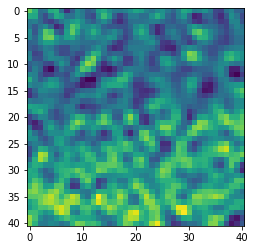

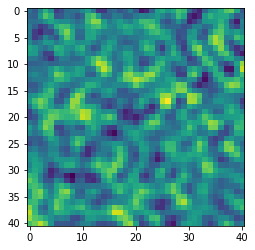

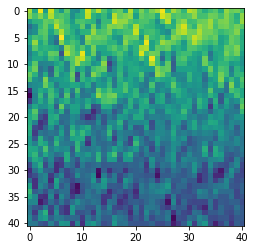

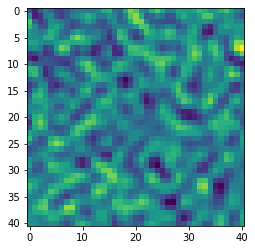

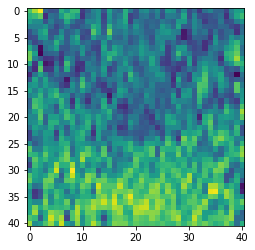

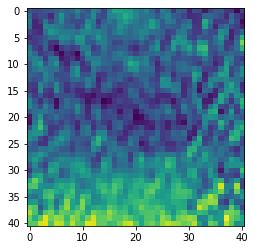

In [39]:
for i in range(10):
    plt.imshow(train_stamps[i,...,1])
    plt.show()
    plt.close()

# Compton y

In [51]:
stamps = []
data_dir = '/project/r/rbond/jorlo/datasets/ml-clusters/for-debug/'

for directory in os.listdir(data_dir):
    print(directory)
    if directory[:3] == 'act':
        h5f = h5py.File(data_dir+directory)
        stamps.append(h5f['act'][:])

stamps = np.vstack(stamps)

stamps = stamps[...,5]

flags = []
for i in range(stamps.shape[0]):
        if np.any(np.isnan(stamps[i,...])):
                flags.append(i)

stamps = np.delete(stamps, flags, axis = 0)

random_2000_w_y.h5
des_5000_w_y.h5
des_2000_w_y.h5
random_0000_w_y.h5
des_0000_w_y.h5
des_1000_w_y.h5
random_6000_w_y.h5
random_7000_w_y.h5
random_5000_w_y.h5
des_6000_w_y.h5
act_1000_w_y.h5
random_4000_w_y.h5
random_3000_w_y.h5
act_3000_w_y.h5
des_4000_w_y.h5
random_1000_w_y.h5
act_0000_w_y.h5
des_3000_w_y.h5


In [52]:
stamps.shape

(1537, 399, 399)